<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/OptimizeLLMs/blob/main/Analise_Robustez_Visao_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 950.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [6]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
import numpy as np

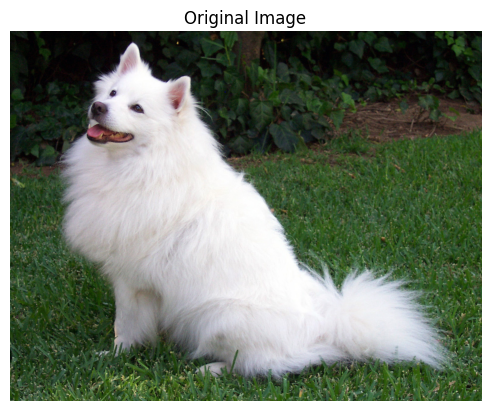

In [7]:
# 🔁 Baixar imagem de exemplo
img_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"  # imagem confiável
response = requests.get(img_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Mostrar imagem original
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

In [8]:
# 🧠 Carregar modelo CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [9]:
# 🏷️ Rótulos candidatos (zero-shot)
labels = ["a photo of a dog", "a photo of a cat", "a photo of a lion", "a photo of a bird"]


In [10]:
# 🔍 Classificação da imagem original
inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
probs = outputs.logits_per_image.softmax(dim=1).detach().numpy()[0]


In [11]:
# Mostrar resultados
for label, prob in zip(labels, probs):
    print(f"{label}: {prob:.4f}")

a photo of a dog: 0.9891
a photo of a cat: 0.0038
a photo of a lion: 0.0067
a photo of a bird: 0.0004


# adição de ruídos

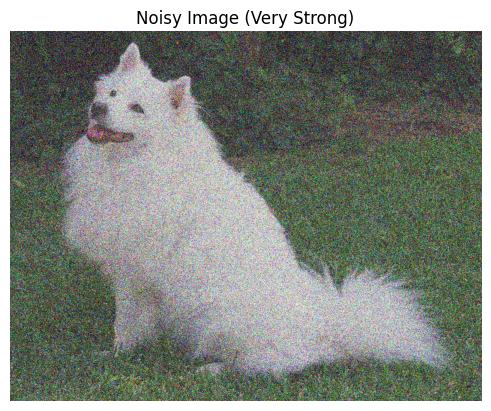

In [17]:
def add_gaussian_noise(img, mean=0, std=150):
    img_np = np.array(img).astype(np.float32)
    noise = np.random.normal(mean, std, img_np.shape)
    noisy_img_np = np.clip(img_np + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img_np)

noisy_image = add_gaussian_noise(image)

# Mostrar imagem com ruído muito forte
plt.imshow(noisy_image)
plt.title("Noisy Image (Very Strong)")
plt.axis("off")
plt.show()

In [18]:
# 🔍 Classificação da imagem com ruído
inputs_noisy = processor(text=labels, images=noisy_image, return_tensors="pt", padding=True)
outputs_noisy = model(**inputs_noisy)
probs_noisy = outputs_noisy.logits_per_image.softmax(dim=1).detach().numpy()[0]

print("\n🔎 Probabilidades após ruído:")
for label, prob in zip(labels, probs_noisy):
    print(f"{label}: {prob:.4f}")


🔎 Probabilidades após ruído:
a photo of a dog: 0.9661
a photo of a cat: 0.0099
a photo of a lion: 0.0233
a photo of a bird: 0.0006


ataques adversariais

In [19]:
!pip install torch torchvision torchattacks --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.25.1 which is incompatible.
sphinx 8.2.3 requires requests>=2.30.0, but you have requests 2.25.1 which is incompatible.
bigframes 1.42.0 requires requests>=2.27.1, but you have requests 2.25.1 which is incompatible.
yfinance 0.2.55 requires requests>=2.31, but you have request

In [20]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchattacks

In [21]:
# Função para mostrar imagem
def imshow(img, title=None):
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


In [22]:
# Transformações para o modelo
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [23]:
# Carregar modelo pré-treinado
model = models.resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Carregar imagem (usando a original ou com ruído leve)
img_tensor = transform(image).unsqueeze(0)  # [1, 3, 224, 224]

✅ Classe predita (antes do ataque): Samoyed


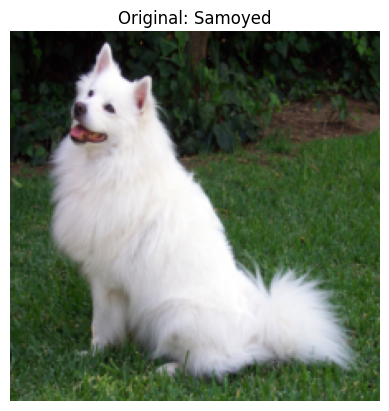

In [25]:
import torchvision.datasets as datasets

# Baixar os nomes das classes do ImageNet
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
import urllib
labels = urllib.request.urlopen(LABELS_URL).read().decode("utf-8").splitlines()

# Predição original
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = output.max(1)
    print(f"✅ Classe predita (antes do ataque): {labels[predicted]}")

imshow(img_tensor.squeeze(), f"Original: {labels[predicted]}")

🚨 Classe predita (após ataque): Persian cat


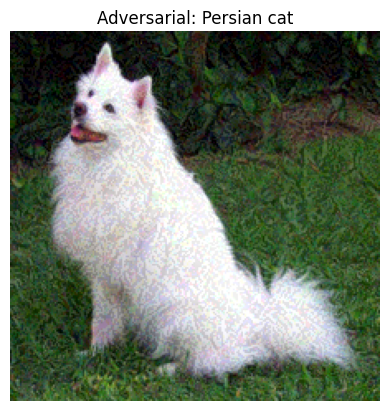

In [26]:
from torchattacks import FGSM

# FGSM (Fast Gradient Sign Method)
attack = FGSM(model, eps=0.05)  # Eps define a intensidade do ataque
adv_img = attack(img_tensor, torch.tensor([predicted]))

# Nova predição com imagem adversarial
with torch.no_grad():
    output_adv = model(adv_img)
    _, adv_pred = output_adv.max(1)
    print(f"🚨 Classe predita (após ataque): {labels[adv_pred]}")

imshow(adv_img.squeeze(), f"Adversarial: {labels[adv_pred]}")

In [27]:
from torchattacks import PGD, DeepFool

# Imagem original deve estar com requires_grad=True para DeepFool
img_tensor.requires_grad = True

def apply_attack(attack, img, label_idx, attack_name):
    adv_img = attack(img, torch.tensor([label_idx]))

    with torch.no_grad():
        output = model(adv_img)
        _, adv_pred = output.max(1)

    imshow(adv_img.squeeze(), f"{attack_name}: {labels[adv_pred]}")
    print(f"{attack_name} predição: {labels[adv_pred]}")

    return adv_img

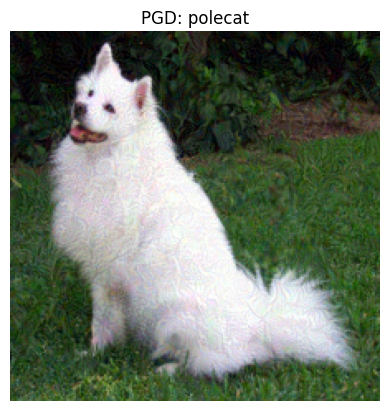

PGD predição: polecat


In [28]:
# Ataque PGD (mais forte que FGSM)
pgd = PGD(model, eps=0.05, alpha=0.01, steps=40)
adv_pgd = apply_attack(pgd, img_tensor, predicted.item(), "PGD")


Mudança de domínio (domain shift)

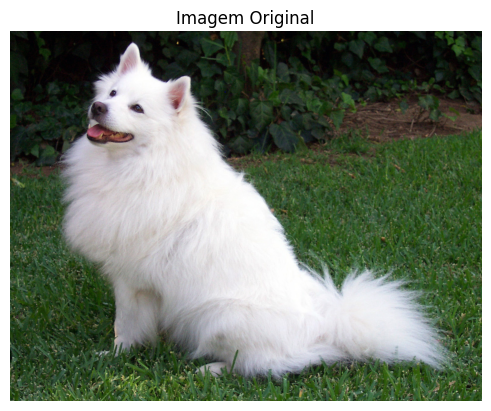

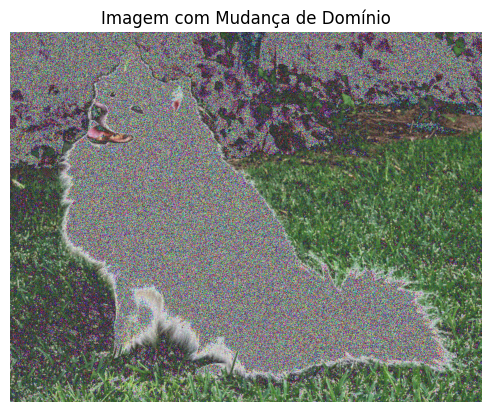

Predição após Mudança de Domínio: window screen


In [43]:
import numpy as np
import torch
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from torchvision import transforms
import requests

# Carregar a imagem original
img_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"  # imagem confiável"
response = requests.get(img_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Exibir imagem original
plt.imshow(image)
plt.title("Imagem Original")
plt.axis("off")
plt.show()

# Função para aplicar o Domain Shift
def apply_domain_shift(image):
    # 1. Alteração de brilho
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.5)  # Aumentar o brilho (valores > 1)

    # 2. Alteração de contraste
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Aumentar o contraste (valores > 1)

    # 3. Alteração de saturação
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(0.5)  # Reduzir a saturação (valores < 1)

    # 4. Adicionar ruído (simulando mudanças no domínio)
    noise = np.random.normal(0, 25, (image.size[1], image.size[0], 3)).astype(np.uint8)  # Ruído
    noisy_image = np.array(image) + noise
    noisy_image = np.clip(noisy_image, 0, 255)  # Garantir que os valores sejam válidos
    image = Image.fromarray(noisy_image.astype(np.uint8))

    return image

# Aplicar mudança de domínio
domain_shifted_image = apply_domain_shift(image)

# Exibir imagem com mudança de domínio
plt.imshow(domain_shifted_image)
plt.title("Imagem com Mudança de Domínio")
plt.axis("off")
plt.show()

# Transformar para tensor para predição
transform = transforms.ToTensor()

# Definir o dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transferir para o dispositivo
img_tensor_shifted = transform(domain_shifted_image).unsqueeze(0).to(device)

# Predição com a imagem alterada (após o Domain Shift)
with torch.no_grad():
    output = model(img_tensor_shifted)
    _, predicted = output.max(1)
    print(f"Predição após Mudança de Domínio: {labels[predicted]}")
